# PYLEECAN model building

In [55]:
import numpy as np
%matplotlib notebook
import pyleecan
import matplotlib.pyplot as plt
# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
import json
from IPython.display import SVG
%matplotlib inline

[13:30:53] Saving MachineSIPMSM to file 'SPM2.json'.
Saving MachineSIPMSM to file 'SPM2.json'.


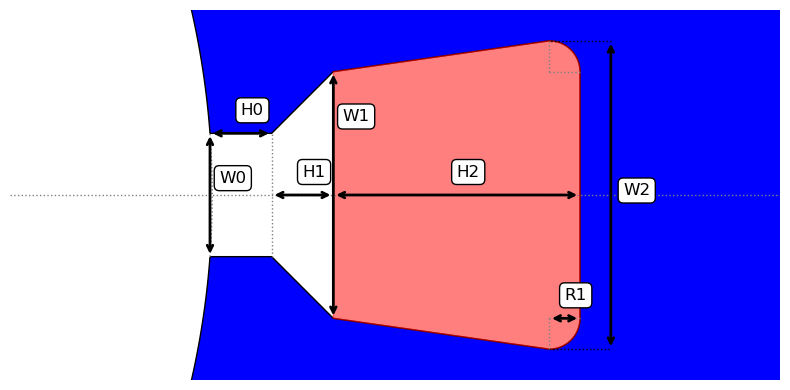

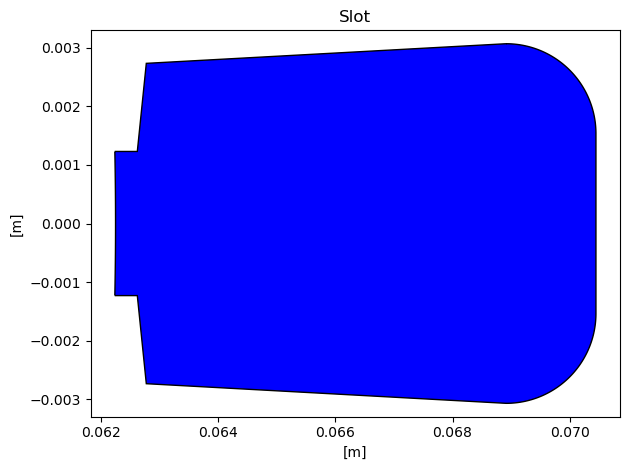

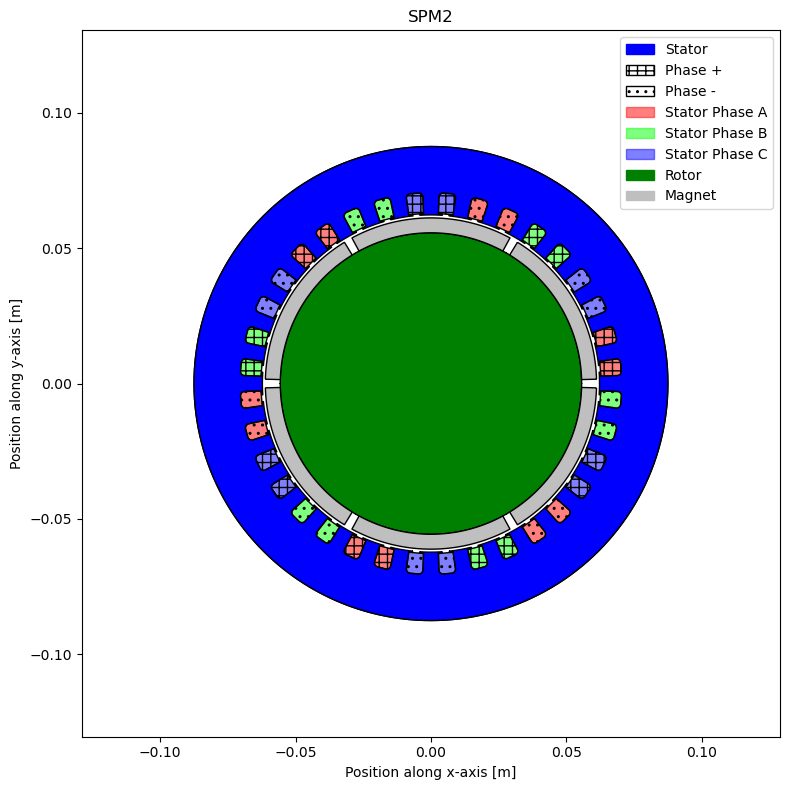

In [56]:
from pyleecan.Classes.LamSlotWind import LamSlotWind
mm = 1e-3  # Millimeter

file = 'dicorca_spm_2.json'
with open(file,'r') as fobj:
    data = json.loads(fobj.read())

# Lamination setup
stator = LamSlotWind(
    Rint=data['stator']['lamination']['Rint'], # internal radius [m]
    Rext=data['stator']['lamination']['Rext'], # external radius [m]
    L1=data['stator']['lamination']['L1'], # Lamination stack active length [m] without radial ventilation airducts 
                # but including insulation layers between lamination sheets
    Nrvd=0, # Number of radial air ventilation duct
    Kf1=data['stator']['lamination']['Kf1'], # Lamination stacking / packing factor
    is_internal=False,
    is_stator=True, 
)

from pyleecan.Classes.SlotW11 import SlotW11

# Slot setup
stator.slot = SlotW11(
    Zs= data['stator']['slot']['Zs'] , # Slot number
    H0= data['stator']['slot']['H0'] , # Slot isthmus height
    H1= data['stator']['slot']['H1'] , # Height
    H2= data['stator']['slot']['H2'] , # Slot height below wedge 
    W0= data['stator']['slot']['W0'] , # Slot isthmus width
    W1= data['stator']['slot']['W1'] , # Slot top width
    W2= data['stator']['slot']['W2'] , # Slot bottom width
    R1= data['stator']['slot']['R1']   # Slot bottom radius
)
fig, ax = stator.slot.plot_schematics(is_default=True, is_show_fig=False)
fig.savefig('./figs/stator_slot_schematics.svg')

fig, ax = stator.slot.plot(is_show_fig=False)
fig.savefig('./figs/stator_slot.svg')


from pyleecan.Classes.Winding import Winding
from pyleecan.Classes.CondType12 import CondType12
# Winding setup
stator.winding = Winding(
    qs=3,  # number of phases
    p= data['p'],  # number of pole pairs
    Nlayer=1,  # Number of layers per slots
    coil_pitch=0, # Coil pitch (or coil span or Throw)
    Lewout=data['stator']['winding']['Lewout'],  # staight length of conductor outside lamination before EW-bend
    Ntcoil=data['stator']['winding']['Ntcoil'],  # number of turns per coil
    Npcp=1,  # number of parallel circuits per phase
    Nslot_shift_wind=0,  # 0 not to change the stator winding connection matrix built by pyleecan number 
                         # of slots to shift the coils obtained with pyleecan winding algorithm 
                         # (a, b, c becomes b, c, a with Nslot_shift_wind1=1)
    is_reverse_wind=False # True to reverse the default winding algorithm along the airgap 
                         # (c, b, a instead of a, b, c along the trigonometric direction)
)

# Conductor setup
# Conductor setup
stator.winding.conductor = CondType12(
    # Nwppc_tan=1, # stator winding number of preformed wires (strands) 
    #              # in parallel per coil along tangential (horizontal) direction
    # Nwppc_rad=1, # stator winding number of preformed wires (strands) 
    #              # in parallel per coil along radial (vertical) direction
    Wwire=data['stator']['conductor']['Wwire'], #  single wire width without insulation [m]
    # Hwire=2e-3, # single wire height without insulation [m]
    Wins_wire=1e-6, # winding strand insulation thickness [m]
    #type_winding_shape=1, # type of winding shape for end winding length calculation
    #                       # 0 for hairpin windings
    #                       # 1 for normal windings
)


from pyleecan.Classes.LamSlotMag import LamSlotMag

# Rotor setup
rotor = LamSlotMag(
    Rint= 0.0, # Internal radius
    Rext= data['rotor']['lamination']['Rext'], # external radius
    is_internal=True, 
    is_stator=False,
    L1=data['rotor']['lamination']['L1'] # Lamination stack active length [m] 
                 # without radial ventilation airducts but including insulation layers between lamination sheets
)

from pyleecan.Classes.HoleM50 import HoleM50
from pyleecan.Classes.SlotM14 import SlotM14

rotor.slot =  SlotM14(
      H0 = 0.0001,
      Hmag= data['rotor']['slot']['Hmag'],
      Rtopm= data['rotor']['slot']['Rtopm'],
      W0=data['rotor']['slot']['W0'],
      Wmag=data['rotor']['slot']['Wmag'],
      Zs=data['rotor']['slot']['Zs'],
    )

from pyleecan.Classes.Material import Material
from pyleecan.Classes.MatMagnetics import MatMagnetics

# Loading Materials 
M800_50A = load(join(DATA_DIR, "Material", "M800-50A.json"))
Copper1 = load(join(DATA_DIR, "Material", "Copper1.json"))

# Set Materials
stator.mat_type = M800_50A  # Stator Lamination material
rotor.mat_type = M800_50A  # Rotor Lamination material
stator.winding.conductor.cond_mat = Copper1  # Stator winding conductor material

# Defining magnets
magnet = Material(name="magnet")

# Definition of the magnetic properties of the material
magnet.mag = MatMagnetics(
    mur_lin = data['rotor']['magnet']['mur_lin'], # Relative magnetic permeability (1.05)
    alpha_Br = -0.001, # temperature coefficient for remanent flux density /°C compared to 20°C
    Brm20 = data['rotor']['magnet']['Brm20'], # magnet remanence induction at 20°C [T] (1.16)
    Wlam = 0, # lamination sheet width without insulation [m] (0 == not laminated)
)

# Definition of the electric properties of the material 
magnet.elec.rho = 1.6e-06 # Resistivity at 20°C

# # Definition of the structural properties of the material
magnet.struct.rho = 7500.0 # mass per unit volume [kg/m3]

# Set magnets in the rotor hole
rotor.magnet.mat_type = magnet
rotor.magnet.type_magnetization = 1

BH = [
    [0.0,0.0],
    [100.0,0.5],
    [150.0,0.7],
    [180.0,0.8],
    [200.0,0.9],
    [250.0,1.0],
    [300.0,1.05],
    [350.0,1.1],
    [450.0,1.15],
    [550.0,1.2],
    [650.0,1.225],
    [750.0,1.25],
    [850.0,1.275],
    [950.0,1.3],
    [1100.0,1.325],
    [1250.0,1.35],
    [1400.0,1.375],
    [1550.0,1.4],
    [1700.0,1.425],
    [1900.0,1.45],
    [2150.0,1.475],
    [2450.0,1.5],
    [2750.0,1.525],
    [3150.0,1.55],
    [3600.0,1.575],
    [4100.0,1.6],
    [4700.0,1.625],
    [5250.0,1.65],
    [6000.0,1.675],
    [6700.0,1.7],
    [7500.0,1.725],
    [8650.0,1.75],
    [9500.0,1.775],
    [10750.0,1.8],
    [14500.0,1.85],
    [19500.0,1.9],
    [25000.0,1.95],
    [33000.0,2.0],
    [44000.0,2.05],
    [57000.0,2.1],
    [74000.0,2.15],
    [96000.0,2.2],
    [130000.0,2.25],
    [170000.0,2.3]
]
# M400_50A.mag.BH_curve = BH
# fig = M400_50A.mag.plot_BH(is_show_fig=False)

stator.winding.comp_connection_mat()  # Compute the winding pattern with swat-em
wind_mat = stator.winding.get_connection_mat()
# The resulting winding matrix is:
# 1 rad layer, 1 tan layer, 48 slots, 3 phases
# print(wind_mat.shape)  
# print(wind_mat)

from pyleecan.Classes.Shaft import Shaft
from pyleecan.Classes.Frame import Frame

# Set shaft
shaft = Shaft(Drsh=rotor.Rint * 2, # Diamater of the rotor shaft [m]
                                   # used to estimate bearing diameter for friction losses
              Lshaft=1.2 # length of the rotor shaft [m] 
             )
frame = None
#frame = Frame(Rint=stator.Rext, Rext=stator.Rext+0.02, Lfra=stator.L1, mat_type=stator.mat_type) 

from pyleecan.Classes.MachineSIPMSM import MachineSIPMSM

SPM2 = MachineSIPMSM(
    name="SPM2", 
    stator=stator, 
    rotor=rotor,
    shaft=shaft, 
    #frame=frame
    )

SPM2.save('SPM2.json')

fig, ax = SPM2.plot(is_show_fig=False)
fig.savefig('./figs/spm_machine.svg')

### Machine

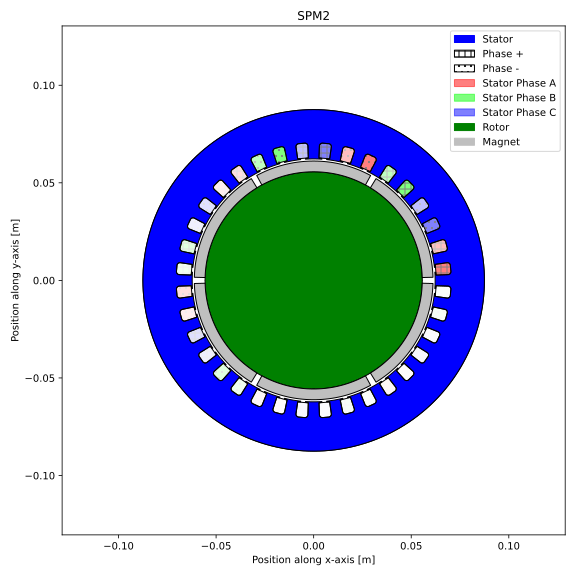

In [57]:
SVG('./figs/spm_machine.svg')

### Rotor

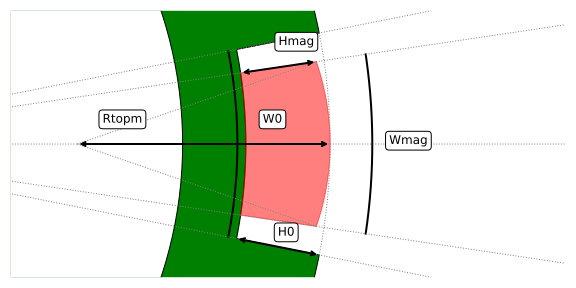

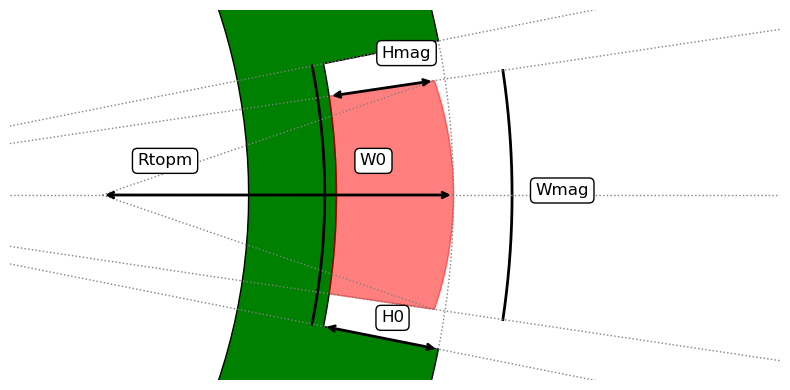

In [58]:
fig, ax = rotor.slot.plot_schematics(is_default=True, is_show_fig=False)
fig.savefig('./figs/rotor_slot_schematic.svg')
SVG('./figs/rotor_slot_schematic.svg')

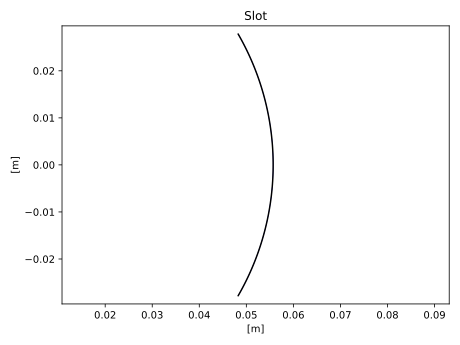

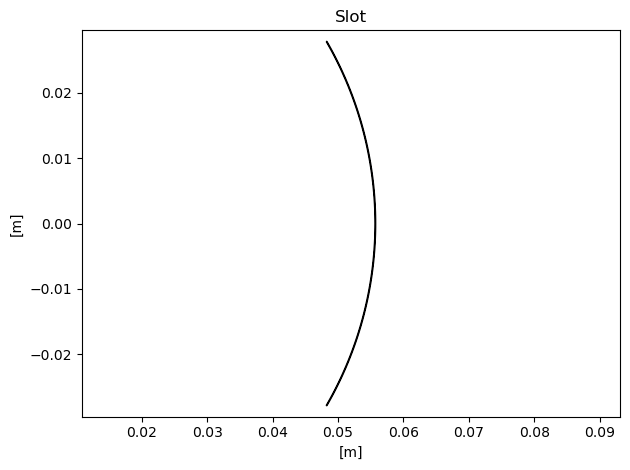

In [59]:
fig, ax = rotor.slot.plot(is_show_fig=False)
fig.savefig('./figs/rotor_slot.svg')
SVG('./figs/rotor_slot.svg')

### Stator

#### Slot

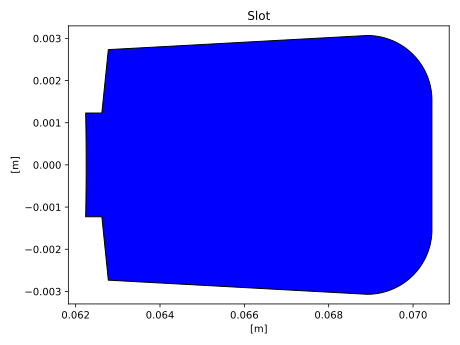

In [60]:
SVG('./figs/stator_slot.svg')

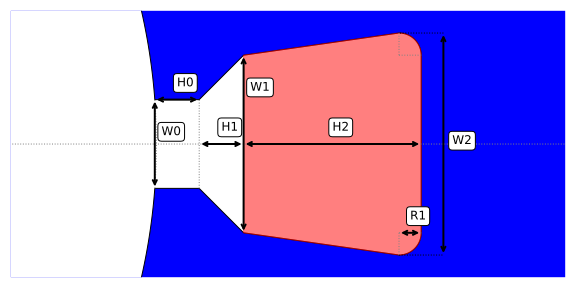

In [61]:
SVG('./figs/stator_slot_schematics.svg')

#### Winding

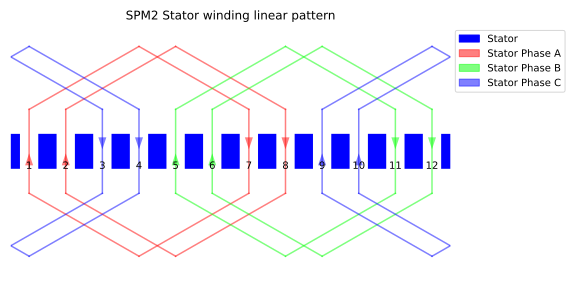

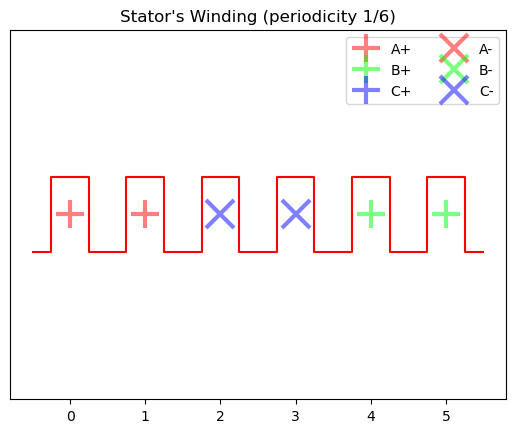

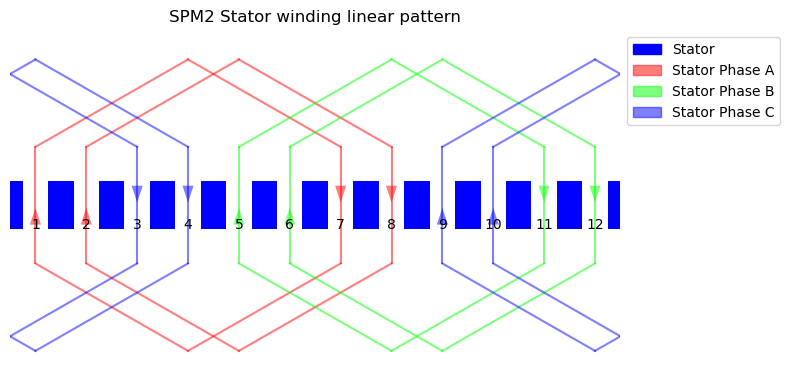

In [62]:
fig, ax = stator.plot_winding(is_show_fig=False)   # Show winding pattern smallest sym
fig.savefig('./figs/stator_plot_winding.svg')
SVG('./figs/stator_plot_winding.svg')

fig, ax = stator.winding.plot_linear(is_show_fig=False)
fig.savefig('./figs/stator_plot_winding_linear.svg')
SVG('./figs/stator_plot_winding_linear.svg')


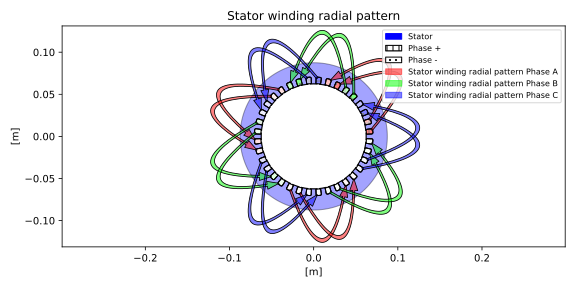

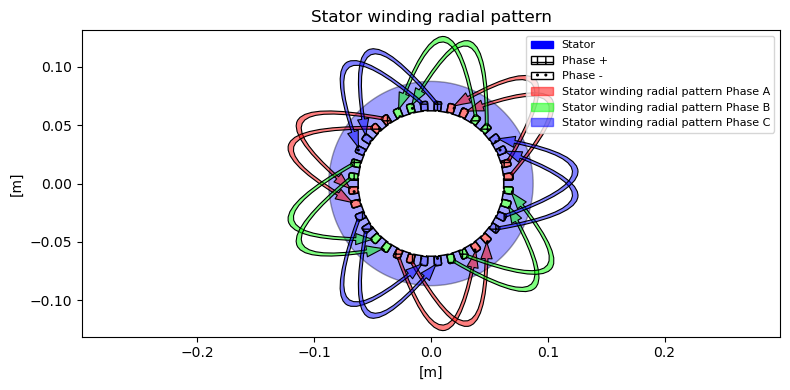

In [63]:
fig, ax = stator.plot(
                is_winding_connection=True,
                is_show_fig=False,
                is_add_sign=True,
            );
fig.savefig('./figs/stator_plot_winding_radial_pattern.svg')
SVG('./figs/stator_plot_winding_radial_pattern.svg')